In [1]:
from torchcraft import replayer
from keras.layers import Input, Dense, Flatten, Reshape, LSTM, RepeatVector
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard

import numpy as np

import matplotlib.pyplot as plt

import cPickle

from sklearn.preprocessing import StandardScaler
import sys
import os

sys.path.insert(0, os.path.abspath('..'))
from utils import data_utils, generate_role_datasets

Using TensorFlow backend.


In [2]:
replay_data = replayer.load('/media/asilva/HD_home/StarData/dumped_replays/1/bwrep_v8os7.tcr')


In [3]:
params = generate_role_datasets.hyper_params()
data_sample = generate_role_datasets.game_over_time(replay=replay_data,
                                                   valid_types=params['valid_units'],
                                                   playerid=2,
                                                   step_size=1,
                                                   feature_set='max',
                                                   add_orders=True)


In [ ]:
def create_temporally_continuous_data(data_in):
    """
    Take in the output from generate_role_datasets.game_over_time() and
    create a new dictionary with an entry for each unit, with the value
    being a list of lists of data for each frame
    """
    temporally_continuous_data = {}
    for i in range(len(data_in)):
        for key, val in data_in[i].iteritems():
            if key in temporally_continuous_data:
                temporally_continuous_data[key].append(val.values())
            else:
                temporally_continuous_data[key] = [val.values()]
    return temporally_continuous_data

data_sample_temp = create_temporally_continuous_data(data_sample)
print data_sample_temp[4][0]

In [13]:
x_in = generate_role_datasets.hmm_data(data_sample, n_timesteps=params['window_size'], for_drawing=False)
x_in = np.array(x_in)

In [14]:
latent_dim = 32
input_dim = len(x_in[0][0])
inputs = Input(shape=(params['window_size'], input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(params['window_size'])(encoded)

decoded = LSTM(input_dim, return_sequences=True)(decoded)

In [15]:
autoencoder = Model(inputs, decoded)
print autoencoder.summary()
autoencoder.compile(optimizer='rmsprop', loss='mean_squared_error')

# encoder = Model(inputs, encoded)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 16, 7)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                5120      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 16, 32)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 16, 7)             1120      
Total params: 6,240
Trainable params: 6,240
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
x_train = x_in[:64000]
x_test = x_in[64000:]
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 64000 samples, validate on 1309 samples
Epoch 1/50
64000/64000 [==============================] - 40s 623us/step - loss: 0.0064 - val_loss: 0.0144
Epoch 2/50
64000/64000 [==============================] - 40s 630us/step - loss: 0.0022 - val_loss: 0.0171
Epoch 3/50
64000/64000 [==============================] - 40s 629us/step - loss: 0.0020 - val_loss: 0.0100
Epoch 4/50
64000/64000 [==============================] - 42s 651us/step - loss: 0.0018 - val_loss: 0.0073
Epoch 5/50
64000/64000 [==============================] - 39s 614us/step - loss: 0.0017 - val_loss: 0.0071
Epoch 6/50
64000/64000 [==============================] - 42s 663us/step - loss: 0.0017 - val_loss: 0.0075
Epoch 7/50
64000/64000 [==============================] - 44s 691us/step - loss: 0.0016 - val_loss: 0.0090
Epoch 8/50
64000/64000 [==============================] - 44s 693us/step - loss: 0.0015 - val_loss: 0.0056
Epoch 9/50
64000/64000 [==============================] - 43s 673us/step - loss: 0.0015 - val_l

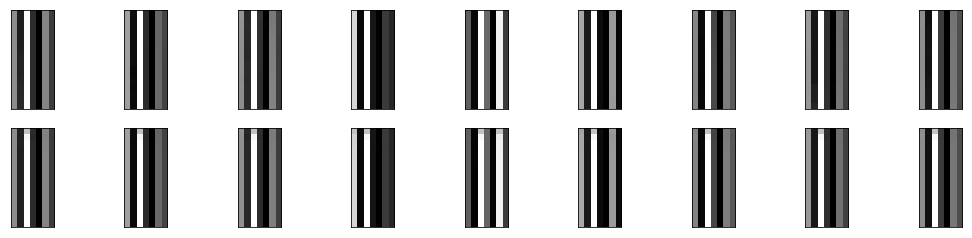

In [17]:
decoded_imgs = autoencoder.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(params['window_size'], input_dim))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(params['window_size'], input_dim))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()